# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a work model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

## Download and explore the data

The dataset is called [Food101](https://www.kaggle.com/datasets/dansbecker/food-101)

In [1]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-11-14 09:56:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.171.207, 64.233.191.207, 173.194.192.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.171.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   202MB/s    in 0.8s    

2023-11-14 09:56:11 (202 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi

## Creating data loaders (preparing the data)

we'll use the `ImageDataGenerator` class to load in our images in batches.

In [2]:
# Setup data input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Test Images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

Training Images:
Found 750 images belonging to 10 classes.
Test Images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run while our model is training)

Classbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular [callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks):

* Tracking experiments with the `TensorBoard` (enables visualizations) callback
* Model checkpoint with the `ModelCheckpoint` (save the model at some frequency) callback
* Stopping a model from training (before it trains to long and overfits) with the `EarlyStopping` Callback

In [3]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to : {log_dir}")
  return tensorboard_callback

> 🔑 **Note:** Can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

## Creating models using TensorFlow Hub

Here we won't create our own models layer by layer from scratch. Instead, we're going to do a similar process, except the majority of our model's layers are going to come from [TensorFlow Hub](https://tfhub.dev/).

We found the following feature vector model links:
* Efficientnet: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
* ResNet: https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

In [4]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [5]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [6]:
# Let's make a create_model() function to create a model from URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the outpur layer,
      should be equal to number of target classes, default 10.
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3, )) # Freeze the already learned patterns
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing **ResNet** TensorFlow Hub Feature Extraction model

In [11]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [12]:
# Compile model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [13]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50v2")])

Saving TensorBoard log files to : tensorflow_hub/resnet50v2/20231114-100552
Epoch 1/5
24/24 [==============================] - 20s 602ms/step - loss: 1.8870 - accuracy: 0.3813 - val_loss: 1.1390 - val_accuracy: 0.6536
Epoch 2/5
24/24 [==============================] - 11s 453ms/step - loss: 0.8864 - accuracy: 0.7347 - val_loss: 0.8191 - val_accuracy: 0.7436
Epoch 3/5
24/24 [==============================] - 11s 469ms/step - loss: 0.6127 - accuracy: 0.8227 - val_loss: 0.7388 - val_accuracy: 0.7660
Epoch 4/5
24/24 [==============================] - 11s 470ms/step - loss: 0.4775 - accuracy: 0.8613 - val_loss: 0.6980 - val_accuracy: 0.7760
Epoch 5/5
24/24 [==============================] - 13s 546ms/step - loss: 0.3860 - accuracy: 0.8960 - val_loss: 0.6625 - val_accuracy: 0.7884


In [7]:
# Let's create a function to visualize the loss curves (create a helper.py script and import next time)
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

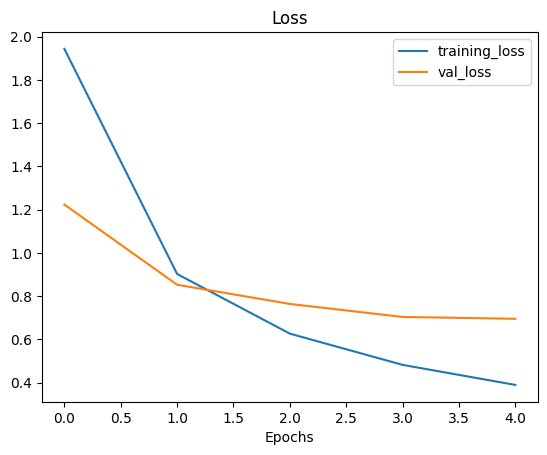

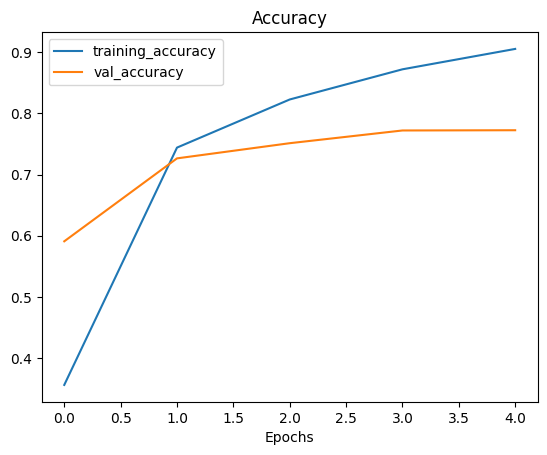

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing **EfficientNetB0** TensorFlow Hub feature Extraction model

In [9]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to : tensorflow_hub/efficientnetb0/20231114-100311
Epoch 1/5
24/24 [==============================] - 31s 499ms/step - loss: 1.8716 - accuracy: 0.4187 - val_loss: 1.3340 - val_accuracy: 0.7144
Epoch 2/5
24/24 [==============================] - 10s 437ms/step - loss: 1.0668 - accuracy: 0.7813 - val_loss: 0.8752 - val_accuracy: 0.8100
Epoch 3/5
24/24 [==============================] - 11s 491ms/step - loss: 0.7487 - accuracy: 0.8440 - val_loss: 0.7020 - val_accuracy: 0.8376
Epoch 4/5
24/24 [==============================] - 10s 410ms/step - loss: 0.5989 - accuracy: 0.8667 - val_loss: 0.6147 - val_accuracy: 0.8516
Epoch 5/5
24/24 [==============================] - 10s 447ms/step - loss: 0.5043 - accuracy: 0.8827 - val_loss: 0.5589 - val_accuracy: 0.8600


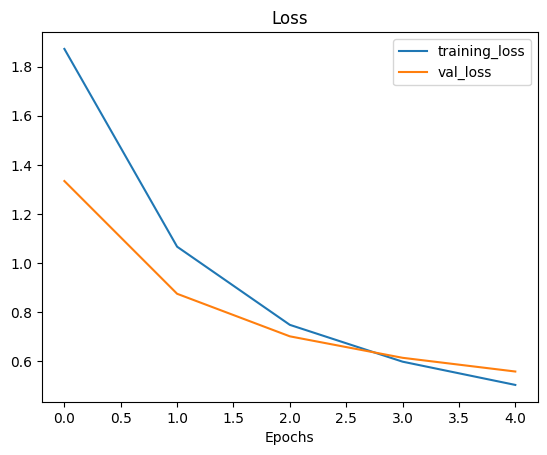

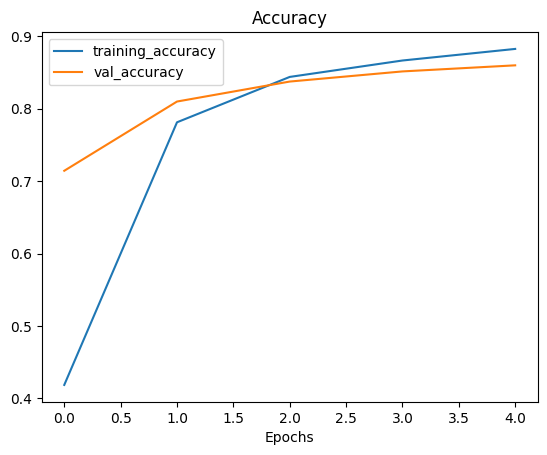

In [10]:
plot_loss_curves(efficientnet_history)

In [14]:
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [16]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [19]:
# How many layers
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model and adjust the output layer for your own problem
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tuning" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> 🔑 **Note:** When you upload things to TensorBoard.dev, your experiments are public. So, if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

In [21]:
# Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./tensorflow_hub/ \
#   --name "EfficientNetB0 vs. ResNet50V2" \
#   --description "Comparing two different TF Hub feateure extraction model architectures using 10% of the training data" \
#   --one_shot

# This will be depricated

2023-11-14 10:32:09.346157: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-14 10:32:09.346211: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-14 10:32:09.346247: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-14 10:32:10.315287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

****************************************************************
****************************************************************
****************************************************************

NOTICE - ACTION REQUIRED: TensorBoard.dev